# **Step 1: Environment Setup**

In [ ]:
# ✅ 1. Clone YOLOv5 and install dependencies
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!pip install opencv-python pillow matplotlib


Cloning into 'yolov5'...
remote: Enumerating objects: 17511, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17511 (delta 5), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17511/17511), 16.60 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (11993/11993), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 

# **Step 2: Load YOLOv5 Model and Filter Classes**

In [ ]:
# ✅ 2. Load pretrained YOLOv5s model
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# ✅ Allowed classes (filtered)
allowed_classes = ['person', 'car', 'bus', 'truck', 'traffic light', 'stop sign']
allowed_ids = [cls_id for cls_id, name in model.names.items() if name in allowed_classes]


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-7-6 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 101MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# **Step 3: JavaScript Webcam Capture Function**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image as IPImage
import PIL
import io
import base64
import cv2
import numpy as np

def capture_image():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', 0.8);
        }
        takePhoto();
    ''')
    display(js)
    data = eval_js("takePhoto()")
    binary = base64.b64decode(data.split(',')[1])
    image = PIL.Image.open(io.BytesIO(binary))
    return image


# **Step 4: Detection Function**

In [4]:
def detect_filtered(image):
    results = model(image)
    df = results.pandas().xyxy[0]
    filtered = df[df['class'].isin(allowed_ids)]

    img = np.array(image.copy())
    for _, row in filtered.iterrows():
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        label = f"{row['name']} {row['confidence']:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # Save output image
    output_path = "detected.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return output_path, img


# **Step 5: Gradio UI for Image Upload and Capture**

In [5]:
import gradio as gr

def gradio_detect(image):
    _, result = detect_filtered(image)
    return result

gr.Interface(
    fn=gradio_detect,
    inputs=gr.Image(type="numpy", label="Upload an Image"),
    outputs=gr.Image(type="numpy", label="Detected Output"),
    title="YOLOv5 - COCO 6-Class Detector",
    description="Detects: person, car, bus, truck, traffic light, stop sign",
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://060fe79a67d7c14bd4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Step 6: Use Webcam in Colab (JavaScript Way)**

<IPython.core.display.Javascript object>

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


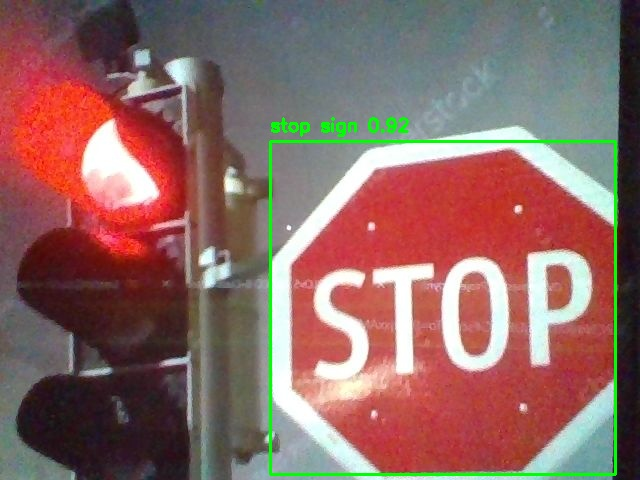

In [8]:
# 📸 Capture via webcam in Colab
image = capture_image()
output_path, _ = detect_filtered(image)
IPImage(output_path)
